# W207 Final Project
## Home Price Prediction
Mona Iwamoto, Michelle Kim, Alex Nocella

### Introduction
This project is based on the Kaggle competition *HOME PRICE PREDICTION*
https://www.kaggle.com/c/house-prices-advanced-regression-techniques. It utilizes the Ames, Iowa data set which contains 79 features. Our goal is to predict the sales prices in the test dataset.  Submissions
to the competition are evaluated base on the Root-Mean-Squared-Error (RMSE) between the *logarithm* of the predicted value and the *logarithm* of the observed sales price.

In [ ]:
#  Import Tools
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import seaborn as sns

from sklearn import ensemble, tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle


In [ ]:
# Import raw data
train_raw = pd.read_csv('train.csv')
print 'Raw data": ', train_raw.shape
test = pd.read_csv('test.csv')
print 'Test data: ', test.shape
train_raw.head()

In [3]:
# Missing Data
NAs = pd.concat([train_raw.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]


,Train,Test
Alley,1369,1352.0
BsmtCond,37,45.0
BsmtExposure,38,44.0
BsmtFinSF1,0,1.0
BsmtFinSF2,0,1.0
BsmtFinType1,37,42.0
BsmtFinType2,38,42.0
BsmtFullBath,0,2.0
BsmtHalfBath,0,2.0
BsmtQual,37,44.0


In [4]:
# Data cleaning for both training and test sets

train_y = train_raw.SalePrice

# Remove features with 50% or greater Missing Data
features = pd.concat([train_raw, test], keys=['train', 'test'])
features.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 
               'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt',
               'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
               'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'],
              axis=1, inplace=True)

# Fill in other missing data
# MSZoning NA in pred. filling with most popular values
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

features['Alley'] = features['Alley'].fillna('NOACCESS')
features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')

# NA's for basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('NoBSMT')
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

# NA's for Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual'):
    features[col] = features[col].fillna('NoGRG')
features['GarageCars'] = features['GarageCars'].fillna(0.0)

# Convert features to appropriate types
features['MSSubClass'] = features['MSSubClass'].astype(str)
features.OverallCond = features.OverallCond.astype(str)
features['KitchenAbvGr'] = features['KitchenAbvGr'].astype(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

# Convert to total square footage
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

# Add GrLivAreaSq
features['GrLivAreaSq'] = features['GrLivArea']**2


In [5]:
features.shape
features.columns.values


array(['Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir',
       'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual',
       'Exterior1st', 'Exterior2nd', 'FireplaceQu', 'Fireplaces',
       'Foundation', 'FullBath', 'GarageCars', 'GarageFinish',
       'GarageQual', 'GarageType', 'GrLivArea', 'HalfBath', 'HeatingQC',
       'HouseStyle', 'Id', 'KitchenAbvGr', 'KitchenQual', 'LandContour',
       'LandSlope', 'LotArea', 'LotConfig', 'LotFrontage', 'LotShape',
       'MSSubClass', 'MSZoning', 'MasVnrType', 'MoSold', 'Neighborhood',
       'OverallCond', 'OverallQual', 'PavedDrive', 'RoofStyle',
       'SaleCondition', 'SalePrice', 'SaleType', 'Street', 'TotRmsAbvGrd',
       'YearBuilt', 'YearRemodAdd', 'YrSold', 'TotalSF', 'GrLivAreaSq'], dtype=object)

In [6]:
features.shape

(2919, 56)

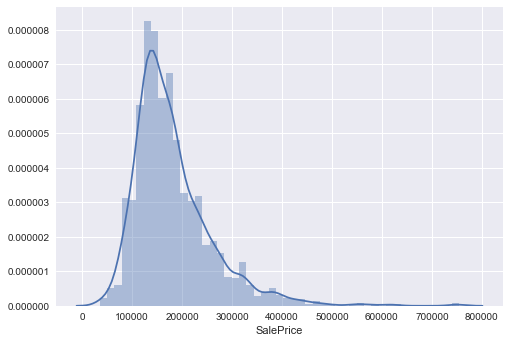

In [7]:
# Transformations 

sns.distplot(train_y)

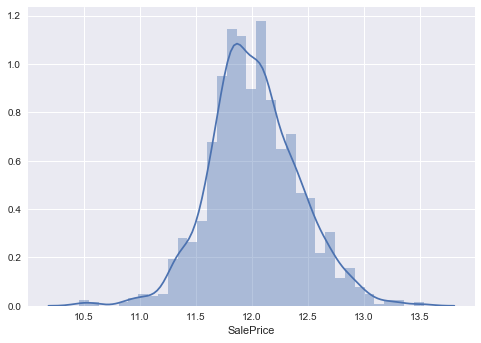

In [8]:
# Large right skew so let's take a log of the SalePrice
train_y = np.log(train_y)
sns.distplot(train_y)

In [9]:
## Standardizing numeric features
numeric_features = features.loc[:,['LotFrontage', 'LotArea', 'GrLivArea', 'TotalSF']]
numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()

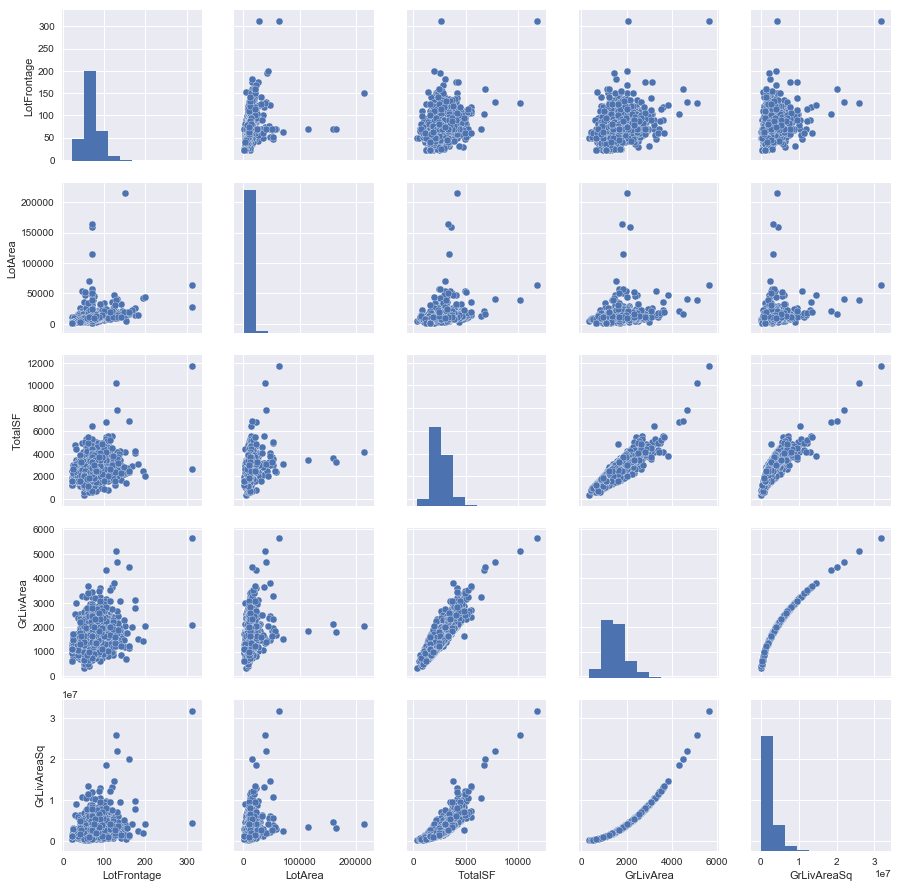

In [10]:
features_to_standardize = [col for col in ['LotFrontage', 'LotArea', 'TotalSF'
                         '', 'GrLivArea', 'GrLivAreaSq'] if col in features.columns]
# Get a flavor of what a few of these variables look like -- they're basically all square footage
sns.pairplot(features[features_to_standardize[0:min(5, len(features_to_standardize))]])

(2919, 56)

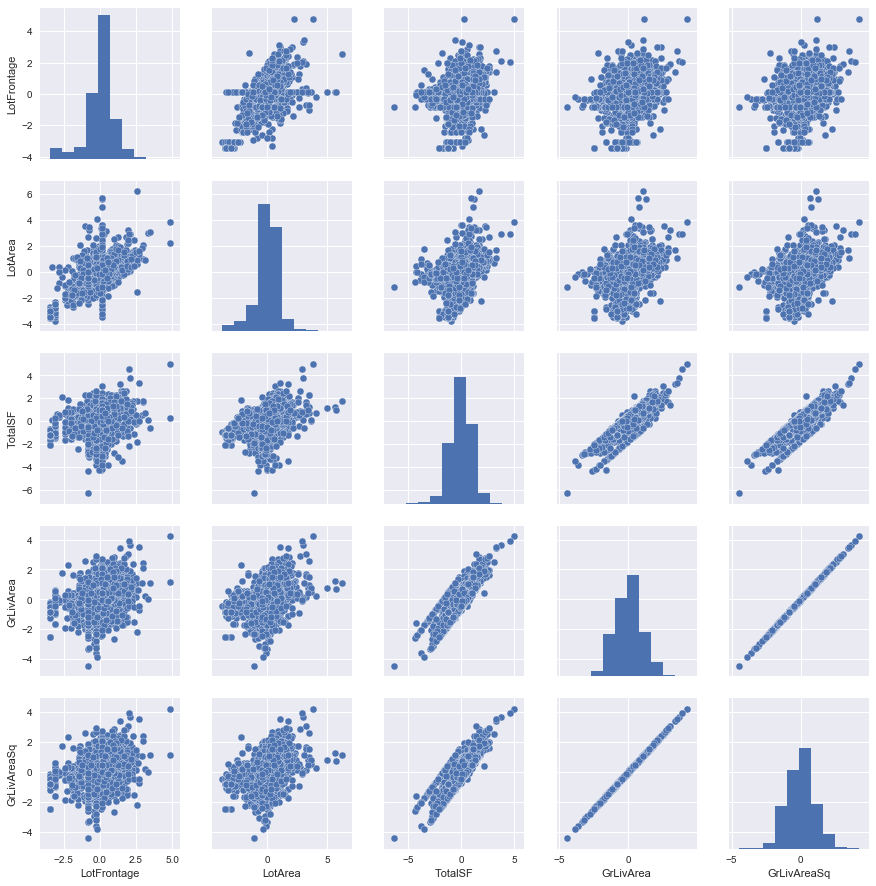

In [11]:
# Take logs, then standardize
def log_and_standardize(df, cols):
    df[cols] = np.log(df[cols] + 1)
    df[cols] = ((df[cols] - df[cols].mean())) / df[cols].std()
    return df
    
features = log_and_standardize(features, features_to_standardize)

# Plot them again
sns.pairplot(features[features_to_standardize[0:min(5, len(features_to_standardize))]])
features.shape


In [12]:
# Create dummy variables for categorical features

# Create dummy from Condition1 and Condition2 
# Condition1: Proximity to various conditions
# Condition2: Proximity to various conditions (if more than one is present)

conditions = set([x for x in features['Condition1']] + [x for x in features['Condition2']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(conditions))),
                       index=features.index, columns=conditions)
for i, cond in enumerate(zip(features['Condition1'], features['Condition2'])):
    dummies.ix[i, cond] = 1
features = pd.concat([features, dummies.add_prefix('Condition_')], axis=1)
features.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

# Create dummy from Exterior1st and Exterior2nd
# Exterior1st: Exterior covering on house
# Exterior2nd: Exterior covering on house (if more than one material)

exteriors = set([x for x in features['Exterior1st']] + [x for x in features['Exterior2nd']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(exteriors))),
                       index=features.index, columns=exteriors)
for i, ext in enumerate(zip(features['Exterior1st'], features['Exterior2nd'])):
    dummies.ix[i, ext] = 1
features = pd.concat([features, dummies.add_prefix('Exterior_')], axis=1)
features.drop(['Exterior1st', 'Exterior2nd', 'Exterior_nan'], axis=1, inplace=True)

# Create other Dummies from all other categorical vars
for col in features.dtypes[features.dtypes == 'object'].index:
    for_dummy = features.pop(col)
    features = pd.concat([features, pd.get_dummies(for_dummy, prefix=col)], axis=1)

/Users/mona/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  
/Users/mona/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


In [13]:
features.shape


(2919, 265)

In [14]:
### Copying features
features_standardized = features.copy()

### Replacing numeric features by standardized values
features_standardized.update(numeric_features_standardized)

In [15]:
### Splitting features
train_features = features.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features = features.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

### Splitting standardized features
train_features_st = features_standardized.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features_st = features_standardized.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

In [36]:
print train_features.shape
print test_features.shape
print train_features_st.shape
print test_features_st.shape


(1460, 264)
(1459, 264)
(1460, 264)
(1459, 264)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [20]:
### Shuffling train sets
train_features_st, train_features, train_y = shuffle(train_features_st, train_features, train_y, random_state = 5)

In [22]:
### Splitting
x_train, x_test, y_train, y_test = train_test_split(train_features, train_y, test_size=0.1, random_state=200)
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_y, test_size=0.1, random_state=200)

In [26]:
print x_train_st.shape
print x_train.shape
print x_test_st.shape
print x_test.shape


(1314, 264)
(1314, 264)
(146, 264)
(146, 264)


In [24]:
# Prints R2 and RMSE scores
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

In [25]:
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(x_train_st, y_train_st)
train_test(ENSTest, x_train_st, x_test_st, y_train_st, y_test_st)

ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], copy_X=True,
       cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99], max_iter=5000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)
R2: 0.971073449396
RMSE: 0.0671387914165
Test
R2: 0.971901356229
RMSE: 0.0592656958806


In [33]:
x_train_st
#Simple LR Original
#simple_LR = linear_model.LinearRegression()
#simple_LR.fit(X = x_train_st[, y = y_train_st.values.reshape(-1, 1))
#train_test(simple_LR, x_train_st, x_test_st, y_train_st, y_test_st)

array([[ 4.,  1.,  2., ...,  0.,  0.,  0.],
       [ 2.,  0.,  1., ...,  0.,  0.,  0.],
       [ 4.,  2.,  1., ...,  1.,  0.,  0.],
       ..., 
       [ 4.,  1.,  2., ...,  0.,  0.,  0.],
       [ 2.,  0.,  2., ...,  0.,  0.,  0.],
       [ 3.,  1.,  2., ...,  0.,  1.,  0.]])

In [29]:
#Simple LR
simple_LR = linear_model.LinearRegression()
simple_LR.fit(X = x_train_st, y = y_train_st.values.reshape(-1, 1))
train_test(simple_LR, x_train_st, x_test_st, y_train_st, y_test_st)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
R2: 0.976701137686
RMSE: 0.0606975325604
Test
R2: 0.968471307502
RMSE: 0.0637605708512


In [30]:
GradBoost = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train, y_train)
train_test(GradBoost, x_train, x_test, y_train, y_test)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=15,
             min_samples_split=10, min_weight_fraction_leaf=0.0,
             n_estimators=3000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
R2: 0.989453684491
RMSE: 0.0405688116063
Test
R2: 0.975902959565
RMSE: 0.0561416937766


In [51]:
GradBoost2 = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train, y_train)
train_test(GradBoost2, x_train_st, x_test_st, y_train_st, y_test_st)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=15,
             min_samples_split=10, min_weight_fraction_leaf=0.0,
             n_estimators=3000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
R2: 0.985715196805
RMSE: 0.0463605291408
Test
R2: 0.976477222833
RMSE: 0.0544776173467


In [40]:
#Maybe Use Decision Tree/Random Forests to Pick Best Features?
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=3, n_estimators=1000)

rf.fit(x_train,y_train)

important_features = np.where(rf.feature_importances_!=0)[0]
for i in important_features:
    print list(x_train)[i]

print len(features)

[  4.00000000e+00   1.00000000e+00   2.00000000e+00   2.00000000e+00
   1.46475218e+00   0.00000000e+00  -4.17626500e-01  -2.95122903e-01
   6.00000000e+00   1.33900000e+05   9.00000000e+00   1.91000000e+03
   1.99800000e+03   1.17062471e+00   1.46460172e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00

In [45]:
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)


In [50]:
#pick the features that the random forest thought were the most important
train_X_sel = x_train.loc[:, x_train.columns[[important_features]]]
dev_X_sel = x_test.loc[:, x_test.columns[[important_features]]]

#fit the regression model using those columns only
rf_LR = linear_model.LinearRegression()
rf_LR.fit(X = train_X_sel, y = y_train)


print("y-intercept: {:,.2f}".format(float(rf_LR.intercept_)))
#print("Other Coefficients:", (rf_LR.coef_))

#make predictions
rf_LR_pred_labels = rf_LR.predict(dev_X_sel)

#print a few actual and predicted values
print y_test[:10]
print rf_LR_pred_labels[:10]

#check the error
print("Log Root Mean Squared Error: {:,.4f}".format(metrics.mean_squared_error((y_test), (rf_LR_pred_labels)) ** 0.5))

# Calculate R-squared values of model.
print("R-squared: {:.2f}".format(metrics.r2_score(y_test, rf_LR_pred_labels)))

y-intercept: 11.16
701     11.849398
141     12.468437
204     11.608236
799     12.072541
194     11.751942
873     11.798104
722     11.732061
952     11.804849
1077    11.840789
645     11.872347
Name: SalePrice, dtype: float64
[ 11.82833692  12.39761447  11.68601753  11.99437621  11.76666519
  11.79512906  11.75480524  11.79939864  11.82264414  11.84375485]
Log Root Mean Squared Error: 0.0932
R-squared: 0.94


In [ ]:
### Splitting features
#train_all = features.loc['train']
#test_all = features.loc['test']

#train_all = features.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
#test_all = features.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

### Splitting standardized features
#train_features_st = features_standardized.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
#test_features_st = features_standardized.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

# Shuffle before splitting
### Shuffling train sets
#train_all, train_y = shuffle(train_all, train_y, random_state = 5)

### Splitting
#train_X, test, train_y, test_y = train_test_split(train_all, train_y, test_size=0.1, random_state=200)
#x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=200)



In [ ]:
train_all.shape

In [ ]:
train_y.shape

In [ ]:


print train_all.shape


# split train into train and dev
train = train_all[:1000]
dev = train_all[1000:]

#train_X= train_all[:1000]
yTemp = train_y.copy()
train_y = yTemp[:1000]
dev_X = train_all[1000:]
dev_y = yTemp[1000:]

# Split into input and output dataframes.
train_X = train.loc[:, train.columns !='SalePrice']
dev_X = dev.loc[:, dev.columns != 'SalePrice']

train_X = train_X.loc[:, train_X.columns !='Id']
dev_X = dev_X.loc[:, dev_X.columns != 'Id']

train_X = train_X[:train_X.shape[0]]

dev_X = dev_X[:dev_X.shape[0]]

print train_X.shape
print train_y.shape
print dev_X.shape
print dev_y.shape
print train_X.head()




In [ ]:
#A little bit of EDA
import seaborn as sns

corrmat2 = train_raw.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat2, vmax=.8, square=True);

corrmat = train_all.corr()
print corrmat.loc[:,corrmat.columns=='SalePrice'].sort_values('SalePrice', ascending=False)

In [ ]:
# Set up simplest linear regression model possible:
simple_LR = linear_model.LinearRegression()
simple_LR.fit(X = train_X.GrLivArea.values.reshape(-1, 1), y = train_y.values.reshape(-1, 1))

print("y-intercept: {:,.2f}".format(float(simple_LR.intercept_)))
print("GrLivArea coefficient: {:,.2f}".format(float(simple_LR.coef_)))

simple_LR_pred_labels = simple_LR.predict(dev_X.GrLivArea.values.reshape(-1, 1))
print("Log Root Mean Squared Error: {:,.2f}".format(metrics.mean_squared_error((dev_y), (simple_LR_pred_labels)) ** 0.5))

# Calculate R-squared values of model.
print("R-squared: {:.2f}".format(metrics.r2_score(dev_y, simple_LR_pred_labels)))

In [ ]:
#Maybe Use Decision Tree/Random Forests to Pick Best Features?
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=3, n_estimators=1000)

rf.fit(train_X,train_y)

#features = np.where(rf.feature_importances_!=0)[0]
#for i in features:
#    print list(train_X)[i]

#print len(features)

In [ ]:
#Write out the csv of predictions
output = dev_X.copy()
output['SalePrice']=simple_LR.predict(output.GrLivArea.values.reshape(-1,1))
output.to_csv('Output.csv',columns=['Id','SalePrice'],index=False)

In [ ]:
# Transformations prior to boosting

#sns.distplot(train_y)

In [ ]:
train_X_xgb = train_X.copy()
dev_X_xgb = dev_X.copy()
test_xgb = test_all.copy()
all_xgb = train_all.copy()

all_xgb_X, all_xgb_y = all_xgb.loc[:, all_xgb.columns !='SalePrice'], all_xgb.loc[:, all_xgb.columns == 'SalePrice']
all_xgb_y = np.log(all_xgb_y)
all_xgb_X = all_xgb_X.loc[:, all_xgb_X.columns !='Id']

# Drop variables that had |correlation| < 0.2 to sale price
def try_to_drop(df, col):
    try:
        df.drop(col, axis=1, inplace=True)
    except Exception:
        pass
    return df

for col in corrmat.SalePrice.loc[np.abs(corrmat.SalePrice) < 0.2].index:
    print col
    train_X_xgb = try_to_drop(train_X_xgb, col)
    dev_X_xgb = try_to_drop(dev_X_xgb, col)
    test_xgb = try_to_drop(test_xgb, col)
    all_xgb_X = try_to_drop(all_xgb_X, col)

features_to_standardize = [col for col in ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
                           'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GrLivAreaSq',
                           'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                           'ScreenPorch', 'PoolArea', 'MiscVal'] if col in train_X_xgb.columns]
# Get a flavor of what a few of these variables look like -- they're basically all square footage
sns.pairplot(train_X_xgb[features_to_standardize[0:min(5, len(features_to_standardize))]])

In [ ]:
# Boosting

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from tabulate import tabulate

def tuner(xgb, param_grid):
    grid_search = GridSearchCV(xgb, param_grid, n_jobs=-1)
    grid_search.fit(train_X_xgb, train_y_xgb)
    print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
    header = ['mean_scr', 'std_scr', 'n_est', 'lrn_rate', 'max_depth', 'gamma', 'subsample', 'reg_alpha']
    rows = []
    for x in grid_search.cv_results_['rank_test_score']:
        rows.append(['{:.6f}'.format(grid_search.cv_results_['mean_test_score'][x-1]),
                     '{:.3f}'.format(grid_search.cv_results_['std_test_score'][x-1]),
                     grid_search.cv_results_['param_n_estimators'][x-1], 
                     grid_search.cv_results_['param_learning_rate'][x-1],
                     grid_search.cv_results_['param_max_depth'][x-1],
                     grid_search.cv_results_['param_gamma'][x-1],
                     grid_search.cv_results_['param_subsample'][x-1],
                     grid_search.cv_results_['param_reg_alpha'][x-1]])
    print tabulate(rows, headers=header, tablefmt='orgtbl')
    return grid_search

def make_param_grid(n_estimators=[100], learning_rate=[0.1], max_depth=[5], gamma=[0], subsample=[0.8], reg_alpha=[0]):
    param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                 gamma=gamma, subsample=subsample, reg_alpha=reg_alpha)
    return param_grid

In [ ]:
conduct_tuning = True

In [ ]:
if conduct_tuning:
    xgb = XGBRegressor()
    n_estimators = [130, 135, 140, 145, 150, 155, 160, 165, 170]
    print('Tuning n_estimators first')
    n_est_result = tuner(xgb, make_param_grid(n_estimators=n_estimators))

In [ ]:
if conduct_tuning:
    max_depth = [3, 4, 5, 6, 7, 8, 9, 10]
    print('Tuning max_depth')
    max_depth_result = tuner(xgb, make_param_grid(max_depth=max_depth,
                                                  n_estimators=[n_est_result.best_params_['n_estimators']]))

In [ ]:
if conduct_tuning:
    gamma = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    print('Tuning gamma')
    gamma_result = tuner(xgb, make_param_grid(gamma=gamma,
                                              n_estimators=[n_est_result.best_params_['n_estimators']],
                                              max_depth=[max_depth_result.best_params_['max_depth']]))

In [ ]:
if conduct_tuning:
    subsample = [0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9]
    print('Tuning subsample')
    subsample_result = tuner(xgb, make_param_grid(subsample=subsample,
                                                  n_estimators=[n_est_result.best_params_['n_estimators']],
                                                  max_depth=[max_depth_result.best_params_['max_depth']],
                                                  gamma=[gamma_result.best_params_['gamma']]))

In [ ]:
if conduct_tuning:
    reg_alpha = [0, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    print('Tuning reg_alpha')
    reg_alpha_result = tuner(xgb, make_param_grid(reg_alpha=reg_alpha,
                                                  n_estimators=[n_est_result.best_params_['n_estimators']],
                                                  max_depth=[max_depth_result.best_params_['max_depth']],
                                                  gamma=[gamma_result.best_params_['gamma']],
                                                  subsample=[subsample_result.best_params_['subsample']]))

In [ ]:
if conduct_tuning:
    learning_rate = [0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14]
    print('Tuning learning_rate')
    learning_rate_result = tuner(xgb, make_param_grid(learning_rate=learning_rate,
                                                      reg_alpha=[reg_alpha_result.best_params_['reg_alpha']],
                                                      n_estimators=[n_est_result.best_params_['n_estimators']],
                                                      max_depth=[max_depth_result.best_params_['max_depth']],
                                                      gamma=[gamma_result.best_params_['gamma']],
                                                      subsample=[subsample_result.best_params_['subsample']]))

In [ ]:
if conduct_tuning:
    print('Re-tuning n_estimators and max_depth for fun')
    n_estimators = [100, 140, 200]
    max_depth = [3, 4, 5]
    gamma = [0]
    subsample = [0.8]
    reg_alpha = [1e-5]
    all_result = tuner(xgb, make_param_grid(learning_rate=learning_rate, reg_alpha=reg_alpha, n_estimators=n_estimators,
                                            max_depth=max_depth, gamma=gamma, subsample=subsample))

In [ ]:
xgb_final_train_model = XGBRegressor(learning_rate=0.1, reg_alpha=1e-5, n_estimators=140, max_depth=4, gamma=0, subsample=0.8)
xgb_final_train_model.fit(train_X_xgb, train_y_xgb)
print("Log Root Mean Squared Error: {:,.4f}"
      .format(mean_squared_error(dev_y_xgb, xgb_final_train_model.predict(dev_X_xgb)) ** 0.5))

In [ ]:
# See if we can make the model more general by improving RMSLE on the dev data with more tuning

conduct_more_tuning = True
to_beat = mean_squared_error(dev_y_xgb, xgb_final_train_model.predict(dev_X_xgb)) ** 0.5
print to_beat

In [ ]:
if conduct_more_tuning:
    best_n_estimators = xgb_final_train_model.get_params()['n_estimators']
    best_max_depth = xgb_final_train_model.get_params()['max_depth']
    print('RMSLE to beat is {:.4f}'.format(to_beat))
    print('Tuning n_estimators and max_depth')
    new_best_found = False
    for n_estimators in [100, 140, 200, 300, 400]:
        for max_depth in [3, 4, 5, 6]:
            xgb_dev_model = XGBRegressor(learning_rate=0.1, reg_alpha=1e-5, n_estimators=n_estimators,
                                         max_depth=max_depth, gamma=0, subsample=0.8)
            xgb_dev_model.fit(train_X_xgb, train_y_xgb)
            new_rmsle = mean_squared_error(dev_y_xgb, xgb_dev_model.predict(dev_X_xgb)) ** 0.5
            if new_rmsle < to_beat:
                new_best_found = True
                print('New best: RMSLE = {:.4f} with n_estimators = {} and max_depth = {}'
                      .format(new_rmsle, xgb_dev_model.get_params()['n_estimators'], xgb_dev_model.get_params()['max_depth']))
                to_beat = new_rmsle
                best_n_estimators = xgb_dev_model.get_params()['n_estimators']
                best_max_depth = xgb_dev_model.get_params()['max_depth']
    if not new_best_found:
        print('No new best found')

In [ ]:
if conduct_more_tuning:
    best_gamma = xgb_final_train_model.get_params()['gamma']
    best_subsample = xgb_final_train_model.get_params()['subsample']
    print('RMSLE to beat is {:.4f}'.format(to_beat))
    print('Tuning gamma and subsample')
    new_best_found = False
    for gamma in [0, 0.1, 0.2]:
        for subsample in [0.7, 0.8, 0.9]:
            xgb_dev_model = XGBRegressor(learning_rate=0.1, reg_alpha=1e-5, n_estimators=140,
                                         max_depth=5, gamma=gamma, subsample=subsample)
            xgb_dev_model.fit(train_X_xgb, train_y_xgb)
            new_rmsle = mean_squared_error(dev_y_xgb, xgb_dev_model.predict(dev_X_xgb)) ** 0.5
            if new_rmsle < to_beat:
                new_best_found = True
                print('New best: RMSLE = {:.4f} with gamma = {} and subsample = {}'
                      .format(new_rmsle, xgb_dev_model.get_params()['gamma'], xgb_dev_model.get_params()['subsample']))
                to_beat = new_rmsle
                best_gamma = xgb_dev_model.get_params()['gamma']
                best_subsample = xgb_dev_model.get_params()['subsample']
    if not new_best_found:
        print('No new best found')

RMSLE to beat is 0.1313
Tuning gamma and subsample
No new best found

In [ ]:
if conduct_more_tuning:
    best_reg_alpha = xgb_final_train_model.get_params()['reg_alpha']
    best_learning_rate = xgb_final_train_model.get_params()['learning_rate']
    print('RMSLE to beat is {:.4f}'.format(to_beat))
    print('Tuning reg_alpha and learning_rate')
    new_best_found = False
    for reg_alpha in [0, 0.1, 0.2]:
        for learning_rate in [0.7, 0.8, 0.9]:
            xgb_dev_model = XGBRegressor(learning_rate=learning_rate, reg_alpha=reg_alpha, n_estimators=140,
                                         max_depth=5, gamma=0, subsample=0.8)
            xgb_dev_model.fit(train_X_xgb, train_y_xgb)
            new_rmsle = mean_squared_error(dev_y_xgb, xgb_dev_model.predict(dev_X_xgb)) ** 0.5
            if new_rmsle < to_beat:
                new_best_found = True
                print('New best: RMSLE = {:.4f} with reg_alpha = {} and learning_rate = {}'
                      .format(new_rmsle, xgb_dev_model.get_params()['reg_alpha'], xgb_dev_model.get_params()['learning_rate']))
                to_beat = new_rmsle
                best_reg_alpha = xgb_dev_model.get_params()['reg_alpha']
                best_learning_rate = xgb_dev_model.get_params()['learning_rate']
    if not new_best_found:
        print('No new best found')

In [ ]:
xgb_optim = XGBRegressor(learning_rate=0.1, reg_alpha=1e-5, n_estimators=140, max_depth=5, gamma=0, subsample=0.8)
xgb_optim.fit(train_X_xgb, train_y_xgb)
plt.scatter(np.log(dev_y), xgb_optim.predict(dev_X_xgb))
plt.title("XGBoost")
plt.xlabel("Log Actual Sale Price")
plt.ylabel("Log Predicted Sale Price")
plt.show()
plt.scatter(np.log(dev_y), np.log(rf_LR_pred_labels))
plt.title("Linear Regression")
plt.xlabel("Log Actual Sale Price")
plt.ylabel("Log Predicted Sale Price")
plt.show()
print("Root Mean Squared Log Error XGBoost: {:,.4f}"
      .format(mean_squared_error(np.log(dev_y), xgb_optim.predict(dev_X_xgb)) ** 0.5))
print("Root Mean Squared Log Error Linear Regression: {:,.4f}"
      .format(mean_squared_error(np.log(dev_y), np.log(rf_LR_pred_labels)) ** 0.5))

In [ ]:
xgb_optim_all_train = XGBRegressor(learning_rate=0.1, reg_alpha=1e-5, n_estimators=140,
                                         max_depth=5, gamma=0, subsample=0.8)
xgb_optim_all_train.fit(all_xgb_X, all_xgb_y)
xgb_predictions = pd.concat([test.Id, pd.Series(np.exp(xgb_optim_all_train.predict(test_xgb)), name='SalePrice')], axis=1)
xgb_predictions.to_csv('Output_xgb.csv', index=False)
print("Root Mean Squared Log Error XGBoost: {:,.4f}"
      .format(mean_squared_error(np.log(dev_y), xgb_optim_all_train.predict(dev_X_xgb)) ** 0.5))

In [ ]:
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(train_X, train_y)
train_test(ENSTest, train_X, test_x, y_train_st, y_test_st)